Jumlah dokumen siap proses: 7881
Mulai mencari jumlah topik terbaik...
Processing k=2...
Processing k=3...
Processing k=4...
Processing k=5...
Processing k=6...
Processing k=7...
Processing k=8...
Processing k=9...
Processing k=10...


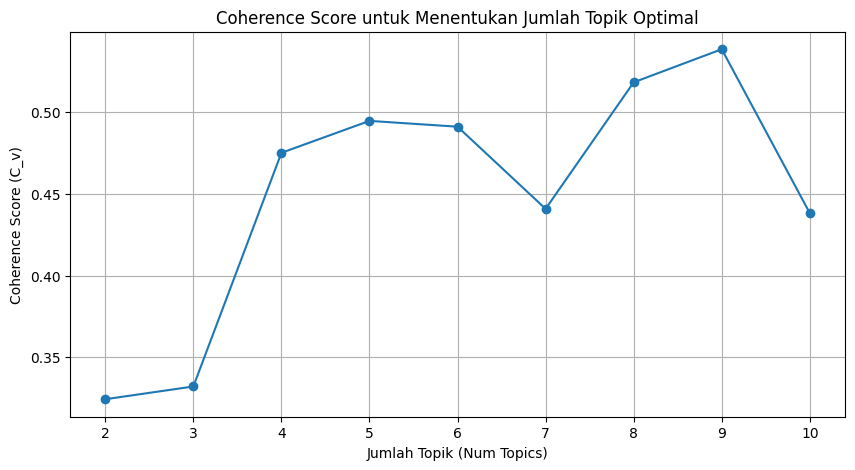

Num Topics = 2, Coherence Score = 0.3244
Num Topics = 3, Coherence Score = 0.3322
Num Topics = 4, Coherence Score = 0.4749
Num Topics = 5, Coherence Score = 0.4944
Num Topics = 6, Coherence Score = 0.4909
Num Topics = 7, Coherence Score = 0.4407
Num Topics = 8, Coherence Score = 0.5180
Num Topics = 9, Coherence Score = 0.5382
Num Topics = 10, Coherence Score = 0.4381

Jumlah topik optimal berdasarkan score tertinggi adalah: 9

Topik pada Model Terbaik (k=9):
Topik 0: 0.067*"bagus" + 0.052*"aplikasi" + 0.036*"mantap" + 0.034*"mudah" + 0.034*"pemula" + 0.032*"saham" + 0.030*"stockbit" + 0.027*"belajar" + 0.026*"membantu" + 0.023*"oke"
Topik 1: 0.024*"masuk" + 0.022*"deposit" + 0.021*"withdraw" + 0.021*"withdrawal" + 0.014*"uang" + 0.014*"verifikasi" + 0.014*"membantu_pemula" + 0.013*"kerja" + 0.011*"proses" + 0.011*"penarikan"
Topik 2: 0.030*"lumayan" + 0.029*"investasi_saham" + 0.025*"the_best" + 0.018*"pokoknya" + 0.017*"gampang" + 0.016*"eror_mulu" + 0.015*"tolong" + 0.015*"tambahin" 

In [5]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import gensim
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel, TfidfModel
from gensim.models.phrases import Phrases, Phraser

# 1. Load Data & Preprocessing
file_path = "hasil_preprocessing.csv"
data = pd.read_csv(file_path)

def parse_list_string(text):
    try:
        return ast.literal_eval(text)
    except:
        return []

data['tokens'] = data['StopwordRemoval'].apply(parse_list_string)
docs = [doc for doc in data['tokens'] if len(doc) > 0]

print(f"Jumlah dokumen siap proses: {len(docs)}")

# 🔥 2. Tambahkan Bigram & Trigram
bigram = Phrases(docs, min_count=3, threshold=10)
trigram = Phrases(bigram[docs], threshold=10)

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

docs = [trigram_mod[bigram_mod[doc]] for doc in docs]  # update tokens dengan n-gram

# 3. Membuat Dictionary dan Corpus (Gensim way)
id2word = corpora.Dictionary(docs)
id2word.filter_extremes(no_below=5, no_above=0.9)

corpus = [id2word.doc2bow(text) for text in docs]

# 3. TF-IDF LDA
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# 4. Fungsi Coherence Score
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []

    print("Mulai mencari jumlah topik terbaik...")
    for num_topics in range(start, limit, step):
        print(f"Processing k={num_topics}...")

        model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=10,
            alpha='auto',
            per_word_topics=True
        )
        model_list.append(model)

        coherencemodel = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

start, limit, step = 2, 11, 1

model_list, coherence_values = compute_coherence_values(
    dictionary=id2word,
    corpus=corpus_tfidf,
    texts=docs,
    start=start,
    limit=limit,
    step=step
)

# 5. Plot
x = range(start, limit, step)
plt.figure(figsize=(10, 5))
plt.plot(x, coherence_values, marker='o')
plt.xlabel("Jumlah Topik (Num Topics)")
plt.ylabel("Coherence Score (C_v)")
plt.title("Coherence Score untuk Menentukan Jumlah Topik Optimal")
plt.grid(True)
plt.show()

# 6. Print Score
for m, cv in zip(x, coherence_values):
    print(f"Num Topics = {m}, Coherence Score = {cv:.4f}")

# 7. Best Model
best_idx = coherence_values.index(max(coherence_values))
best_k = x[best_idx]
best_lda_model = model_list[best_idx]

print(f"\nJumlah topik optimal berdasarkan score tertinggi adalah: {best_k}")
print(f"\nTopik pada Model Terbaik (k={best_k}):")
for idx, topic in best_lda_model.print_topics(-1):
    print(f"Topik {idx}: {topic}")